In [3]:
%pip install scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np



  Using cached scikit_learn-1.7.1-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.1-cp310-cp310-win_amd64.whl (8.9 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify first conv layer for 1-channel (grayscale)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify output layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}% "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "E:\\Projects\\oil_spill_detection\\models\\esnet18_baseline.pth")

    return train_losses, val_losses


In [35]:

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image
import os

csv_path = "E:\\Projects\\oil_spill_detection\\data\\labels.csv"
root_dir = "E:\\Projects\\oil_spill_detection\\data\\"

class OilSpillDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert("L")  # grayscale
        label = int(self.data.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset
full_dataset = OilSpillDataset(csv_file="E:\\Projects\\oil_spill_detection\\data\\labels.csv", root_dir=root_dir, transform=transform)

# Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [36]:
num_epochs = 10
train_losses, val_losses = train_model(model, train_loader, val_loader,
                                       criterion, optimizer, num_epochs=num_epochs)



Epoch [1/10] Train Loss: 0.0730, Train Acc: 97.27% Val Loss: 0.0862, Val Acc: 97.34%
Epoch [2/10] Train Loss: 0.0531, Train Acc: 98.07% Val Loss: 0.0622, Val Acc: 97.96%
Epoch [3/10] Train Loss: 0.0551, Train Acc: 98.00% Val Loss: 0.0803, Val Acc: 97.16%
Epoch [4/10] Train Loss: 0.0302, Train Acc: 99.07% Val Loss: 0.0498, Val Acc: 97.96%
Epoch [5/10] Train Loss: 0.0081, Train Acc: 99.84% Val Loss: 0.0648, Val Acc: 97.78%
Epoch [6/10] Train Loss: 0.0257, Train Acc: 99.22% Val Loss: 0.0810, Val Acc: 97.96%
Epoch [7/10] Train Loss: 0.0152, Train Acc: 99.51% Val Loss: 0.0652, Val Acc: 97.96%
Epoch [8/10] Train Loss: 0.0069, Train Acc: 99.82% Val Loss: 0.0537, Val Acc: 98.05%
Epoch [9/10] Train Loss: 0.0184, Train Acc: 99.33% Val Loss: 0.1538, Val Acc: 95.29%
Epoch [10/10] Train Loss: 0.0363, Train Acc: 99.02% Val Loss: 0.0843, Val Acc: 96.98%


              precision    recall  f1-score   support

      No Oil       0.99      0.99      0.99       750
   Oil Spill       0.97      0.97      0.97       376

    accuracy                           0.98      1126
   macro avg       0.98      0.98      0.98      1126
weighted avg       0.98      0.98      0.98      1126

Confusion Matrix:
 [[739  11]
 [ 11 365]]


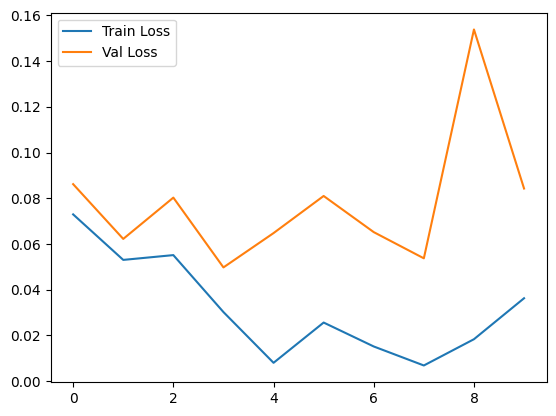

In [41]:
# Load best model
model.load_state_dict(torch.load("E:\Projects\oil_spill_detection\models\esnet18_baseline.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["No Oil", "Oil Spill"]))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()


In [24]:
import torch

if torch.cuda.is_available():
    print("✅ CUDA is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ CUDA not available, running on CPU.")


✅ CUDA is available!
Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [1]:
import sys
print(sys.executable)

import sklearn
print("scikit-learn version:", sklearn.__version__)


e:\Projects\oil_spill_detection\oil_spill_detection_env\Scripts\python.exe


ModuleNotFoundError: No module named 'sklearn'

In [5]:
import sys
print(sys.executable)


e:\Projects\oil_spill_detection\oil_spill_detection_env\Scripts\python.exe
